Summary Statistics:
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      201.957515     116.376337     113.720571     206.643095   
std       298.495150     218.652659     158.946032     300.896893   
min       -19.500000      -7.800000     -17.900000       0.000000   
25%        -2.800000      -0.300000      -3.800000       0.000000   
50%         0.300000      -0.100000      -0.100000       3.600000   
75%       362.400000     107.000000     224.700000     359.500000   
max      1499.000000     946.000000     892.000000    1507.000000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      198.114691      26.319394      79.448857       1.146113   
std       288.889073       4.398605      20.520775       1.239248   
min         0.000000      12.300000       9.900000       0.000000   
25%         0

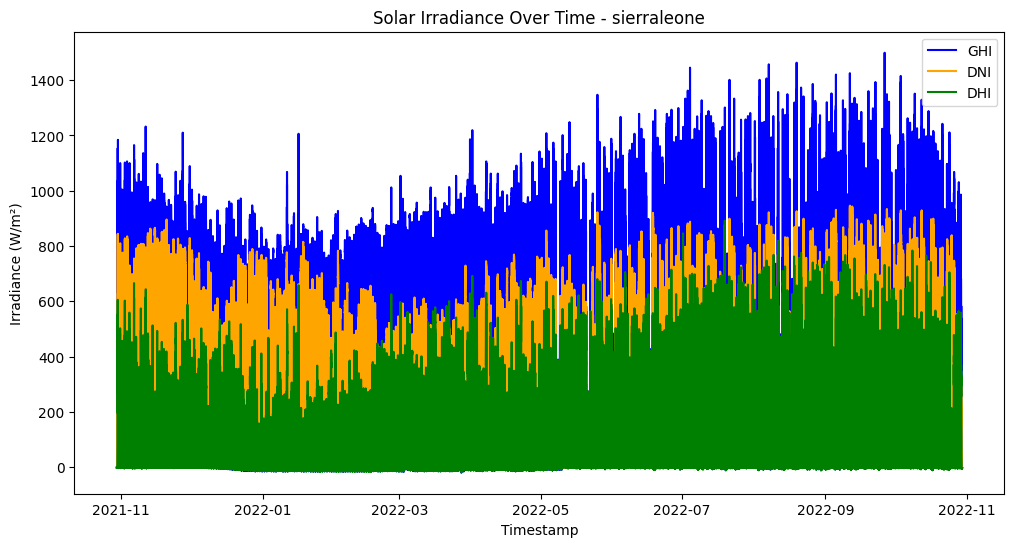


Cleaning Impact:
                ModA        ModB
Cleaning                        
0         206.578599  198.038150
1         273.309252  277.231102


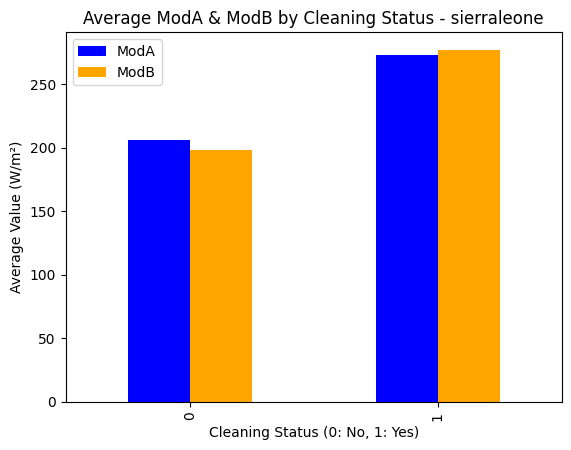

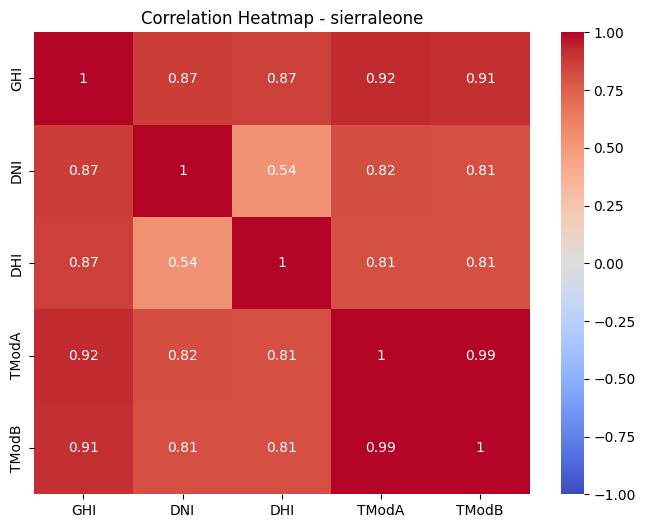

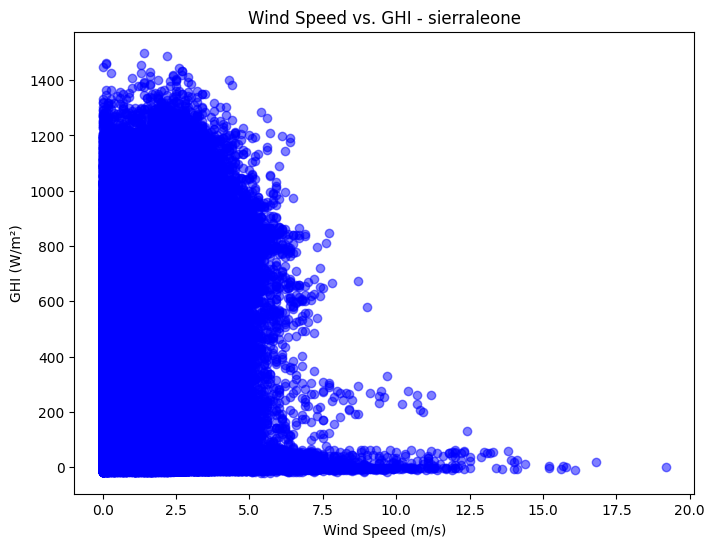

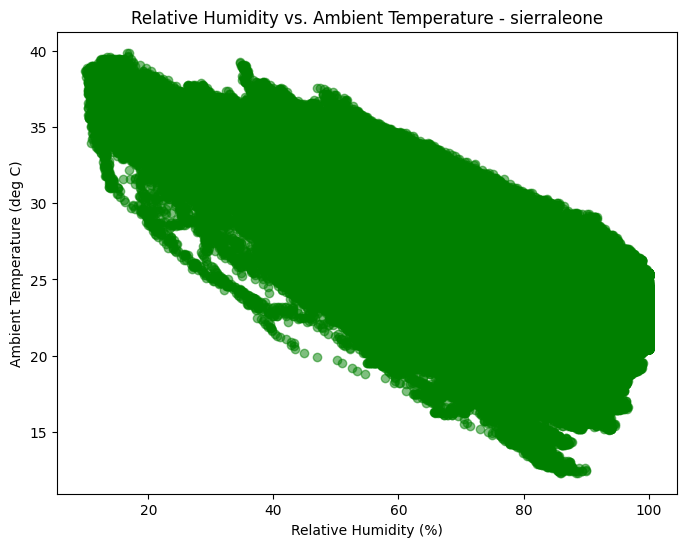

Error displaying wind rose plot: Mime type rendering requires nbformat>=4.2.0 but it is not installed


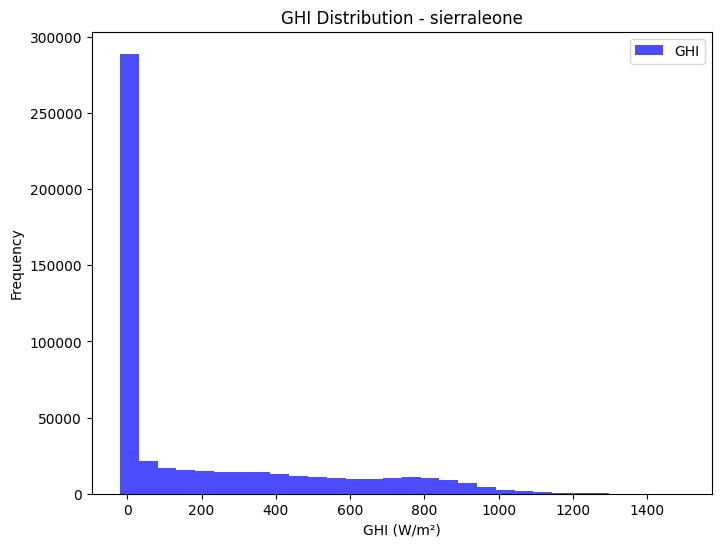

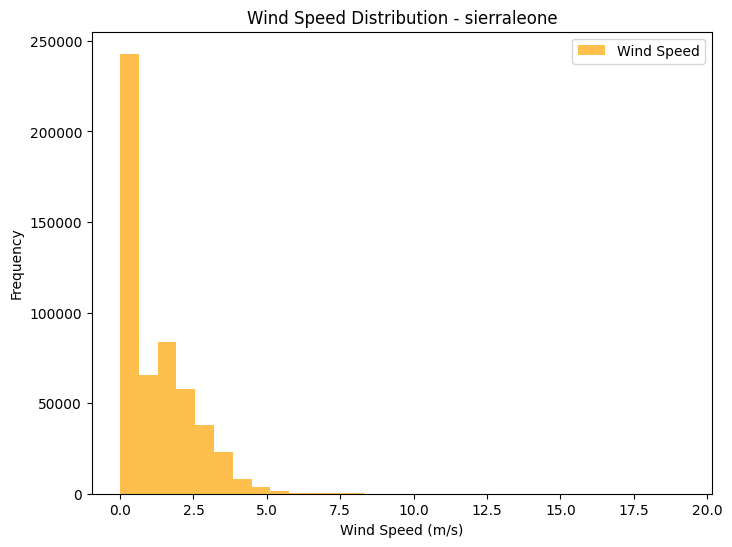

Error displaying bubble chart: Mime type rendering requires nbformat>=4.2.0 but it is not installed


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import plotly.graph_objects as go
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load data
try:
    df = pd.read_csv('../data/sierraleone-bumbuna.csv')
except FileNotFoundError:
    print("Error: '../data/sierraleone-bumbuna.csv' not found. Please ensure the file exists.")
    raise

# Summary Statistics
print('Summary Statistics:')
print(df.describe())
print('\nMissing Values:')
missing = df.isna().sum()
print(missing[missing > 0])
missing_pct = (missing / len(df)) * 100
print('\nColumns with >5% missing:')
print(missing_pct[missing_pct > 5])

# Outlier Detection
key_cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
z_scores = df[key_cols].apply(zscore, nan_policy='omit')
outliers = z_scores.apply(lambda x: (x.abs() > 3).sum())
print('\nOutliers (|Z|>3):')
print(outliers)

# Cleaning: Impute missing values with median
for col in key_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Export cleaned data
df.to_csv('../data/sierraleone_clean.csv', index=False)
print('\nCleaned data exported to ../data/sierraleone_clean.csv')

# Time Series Analysis
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI', color='blue')
plt.plot(df['Timestamp'], df['DNI'], label='DNI', color='orange')
plt.plot(df['Timestamp'], df['DHI'], label='DHI', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.title('Solar Irradiance Over Time - sierraleone')
plt.legend()
plt.show()
plt.close()

# Cleaning Impact
cleaning_impact = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
print('\nCleaning Impact:')
print(cleaning_impact)
cleaning_impact.plot(kind='bar', title='Average ModA & ModB by Cleaning Status - sierraleone', color=['blue', 'orange'])
plt.xlabel('Cleaning Status (0: No, 1: Yes)')
plt.ylabel('Average Value (W/m²)')
plt.show()
plt.close()

# Correlation Heatmap
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr = df[corr_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap - sierraleone')
plt.show()
plt.close()

# Scatter Plots
plt.figure(figsize=(8, 6))
plt.scatter(df['WS'], df['GHI'], alpha=0.5, color='blue')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('GHI (W/m²)')
plt.title('Wind Speed vs. GHI - sierraleone')
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
plt.scatter(df['RH'], df['Tamb'], alpha=0.5, color='green')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (deg C)')
plt.title('Relative Humidity vs. Ambient Temperature - sierraleone')
plt.show()
plt.close()

# Wind Rose using go.Barpolar
bins = np.arange(0, 360 + 30, 30)
df['WD_bin'] = pd.cut(df['WD'], bins=bins, include_lowest=True, right=False)
wind_rose_data = df.groupby('WD_bin')['WS'].mean().reset_index()
wind_rose_data['theta'] = [bin.mid for bin in wind_rose_data['WD_bin']]

fig = go.Figure(data=[
    go.Barpolar(
        r=wind_rose_data['WS'],
        theta=wind_rose_data['theta'],
        marker_color='blue',
        opacity=0.8
    )
])
fig.update_layout(
    title='Wind Rose - sierraleone',
    polar=dict(
        radialaxis=dict(visible=True),
        angularaxis=dict(direction="clockwise")
    )
)
try:
    fig.show()
except Exception as e:
    print(f"Error displaying wind rose plot: {e}")

# Histograms
plt.figure(figsize=(8, 6))
plt.hist(df['GHI'], bins=30, alpha=0.7, label='GHI', color='blue')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')
plt.title('GHI Distribution - sierraleone')
plt.legend()
plt.show()
plt.close()

plt.figure(figsize=(8, 6))
plt.hist(df['WS'], bins=30, alpha=0.7, label='Wind Speed', color='orange')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Wind Speed Distribution - sierraleone')
plt.legend()
plt.show()
plt.close()

# Bubble Chart
fig = go.Figure(data=[
    go.Scatter(
        x=df['Tamb'],
        y=df['GHI'],
        mode='markers',
        marker=dict(
            size=df['RH'],
            sizemode='area',
            sizeref=2.*max(df['RH'])/(40.**2),
            color='blue',
            opacity=0.6
        )
    )
])
fig.update_layout(
    title='GHI vs. Tamb (Bubble Size: RH) - sierraleone',
    xaxis_title='Ambient Temperature (deg C)',
    yaxis_title='GHI (W/m²)'
)
try:
    fig.show()
except Exception as e:
    print(f"Error displaying bubble chart: {e}")